# Notebook 5: Scoring algorithm

In this notebook, we will show how to partially reproduce our scoring system for the competition.

In order to prevent participants from overfiting on the entire score, we will show how to reproduce the scoring only on the first term of the score (RC - Results consistency).

## Setup

There is no hard constraint on the data format to respect for this, in this notebook we will simply show you how to reproduce it with the set of our internal experiments.

In order to get started, first make sure to follow the same JSON format at the example file below (again, you can adapt the script to use your own format):

In [ ]:
!wget https://raw.githubusercontent.com/et-slm-evaluation/et-slm-evaluation.github.io/refs/heads/main/assets/data/plot-data-combined-all.json

--2025-04-25 06:51:35--  https://raw.githubusercontent.com/et-slm-evaluation/et-slm-evaluation.github.io/refs/heads/main/assets/data/plot-data-combined-all.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 135783 (133K) [text/plain]
Saving to: ‘plot-data-combined-all.json’

plot-data-combined- 100%[===================>] 132.60K  --.-KB/s    in 0.003s  

2025-04-25 06:51:35 (38.9 MB/s) - ‘plot-data-combined-all.json’ saved [135783/135783]



```json
{
  "data": {
    "arch1": {
      "model_type": [
        "Competition-Proposal"
      ],
      "experiment": [
        "exp-name"
      ],
      "iteration": [
        2000
      ],
      "benchmark_1": [
        0.333
      ]
      "benchmark_2": [
        0.666
      ]
    }
  }
}
```

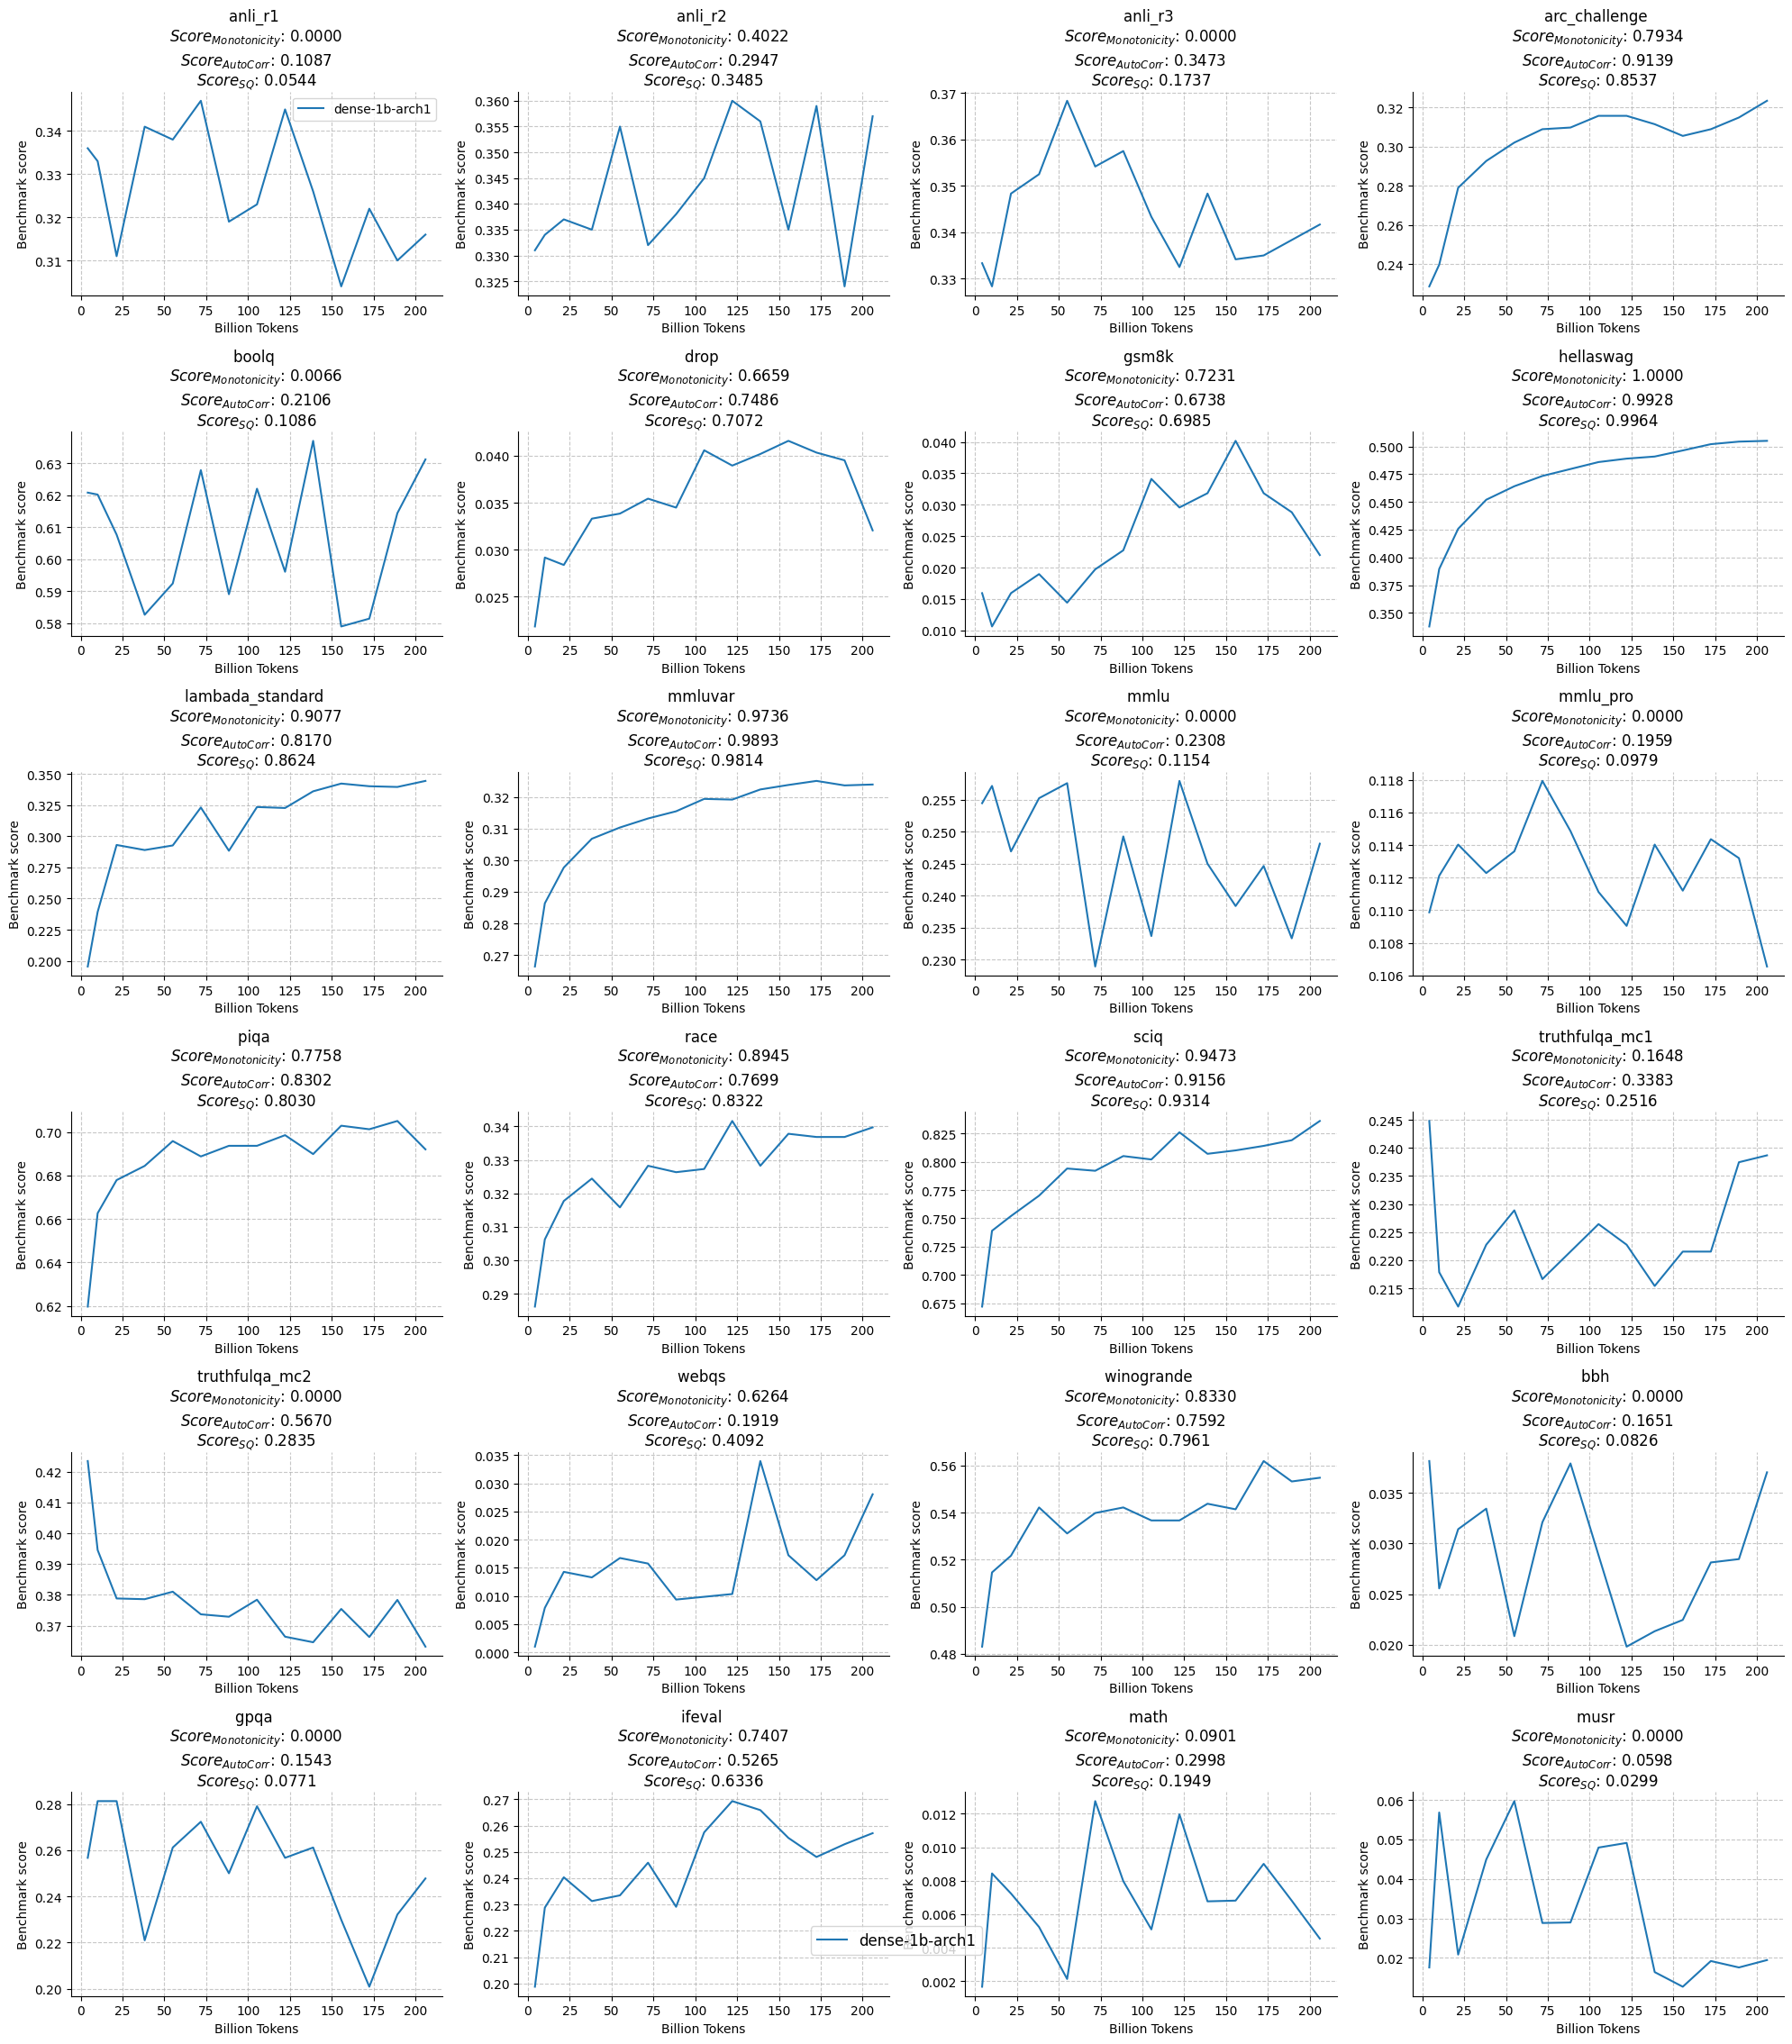

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import json

def var(a):
    return sum((a - np.mean(a))**2) / len(a)

def normalize(a, min_a, max_a):
    return (a - min_a) / (max_a - min_a + 1e-20)

def autocorrelation(signal, lag=1):
    """Compute the autocorrelation at given lag."""
    n = len(signal)
    s1 = signal[lag:]
    s2 = signal[:n-lag]
    return np.corrcoef(s1, s2)[0, 1]

def spearmancorrelation(a):
    x, y = np.array(range(len(a))), np.array(a)

    # Get ranks
    x_rank = np.argsort(np.argsort(x))
    y_rank = np.argsort(np.argsort(y))

    n = len(x)
    d_squared_sum = np.sum((x_rank - y_rank)**2)
    rho = 1 - (6 * d_squared_sum) / (n * (n**2 - 1))
    return max(rho, 0)

def signal_quality_score(a):
    a_new = a
    sc = spearmancorrelation(a_new)
    ac = np.mean([np.abs(autocorrelation(a_new, i)) for i in range(1,len(a_new)//4)])
    return sc, ac, (sc + ac)/2


def convert_iter_to_gt(a):
    global_batch_size = 1024
    batch_size_rampup = [256, 256, 4882812]
    seq_len = 4096

    num_phases = global_batch_size / batch_size_rampup[1]
    num_samples_per_phase = batch_size_rampup[2] / (num_phases - 1)

    batch_size_per_phase = np.arange(batch_size_rampup[0], global_batch_size+1, batch_size_rampup[1])
    num_samples_per_phase_vec = np.ones(int(num_phases)) * num_samples_per_phase
    num_iter_per_phase = num_samples_per_phase_vec / batch_size_per_phase
    num_iter_per_phase[-1] = np.max(a) - np.sum(num_iter_per_phase[:-1])

    a_gt = []
    num_iter_per_phase_cumsum = np.cumsum(num_iter_per_phase)

    for i in range(len(a)):
        iter_idx = np.searchsorted(num_iter_per_phase_cumsum, a[i])
        if iter_idx > 0:
            a_gt.append(np.sum([num_iter_per_phase[j] * batch_size_per_phase[j] * seq_len for j in range(iter_idx)] +\
                        [(a[i] - num_iter_per_phase_cumsum[iter_idx-1]) * batch_size_per_phase[iter_idx] * seq_len])/1e9)
        else:
            a_gt.append((a[i] * batch_size_per_phase[iter_idx] * seq_len)/1e9)
    return a_gt


#################################################################################################
#################################################################################################
#################################################################################################
#################################################################################################

path = 'plot-data-combined-all.json'
with open(path, 'r') as file:
    data = json.load(file)['data']

benchmarks = ["anli_r1","anli_r2", "anli_r3", "arc_challenge", "boolq", "drop", "gsm8k", "hellaswag", "lambada_standard", "mmluvar", "mmlu", "mmlu_pro", "piqa", "race", "sciq", "truthfulqa_mc1", "truthfulqa_mc2", "webqs", "winogrande", "bbh", "gpqa", "ifeval", "math", "musr"]

#################################################################################################
#################################################################################################
#################################################################################################
#################################################################################################

results_signal_quality = {}
models = ['dense-1b-arch1']

p = 1
num_sheets = len(models) * len(benchmarks)
cols = 4
rows = math.ceil(num_sheets / cols)
plt.figure(figsize=(5*cols, 4*rows))
plt.subplots_adjust(hspace=0.6, wspace=0.3, top=0.95)

for model in models:
    results_signal_quality[model] = {}
    for benchmark in benchmarks:
        iters_0 = data[model]['iteration']
        a_scores = data[model][benchmark]
        a_scores = list(filter(lambda x: x[0]%4000==0 ,list(zip(iters_0, data[model][benchmark]))))
        iters_gt = convert_iter_to_gt(list(map(lambda x: x[0], a_scores)))
        merged = list(zip(iters_gt, list(map(lambda x: x[0], a_scores)),list(map(lambda x: x[1], a_scores))))
        merged = list(filter(lambda x: x[0] <= 206, merged))


        rho, ac, score = signal_quality_score(np.array(list(map(lambda x: x[2], merged))))
        results_signal_quality[model][benchmark] = (rho, ac, score)

        # Create subplot - use correct row/col ordering
        ax = plt.subplot(rows, cols, p)

        ax.plot(np.array(list(map(lambda x: x[0], merged))), np.array(list(map(lambda x: x[2], merged))), linewidth=1.5, label=model)

        # Add title with less padding
        ax.set_title(f"{benchmark} \n" + r"$Score_{Monotonicity}$:" + f" {rho:.4f} \n" + r"$Score_{AutoCorr}$:" + f" {ac:.4f} \n" + r"$Score_{SQ}$:" + f" {score:.4f}", pad=5)

        ax.set_xlabel("Billion Tokens")
        ax.set_ylabel("Benchmark score")
        ax.grid(True, linestyle='--', alpha=0.7)
        if p==1:
            ax.legend()
        p += 1
        # Add some visual improvement
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig = plt.gcf()  # Get current figure
fig.legend(
    by_label.values(),
    by_label.keys(),
    loc='lower center',
    bbox_to_anchor=(0.5, 0.04),  # Position at bottom center
    ncol=3,  # Show items in 3 columns
    fontsize=12,
    frameon=True  # Add a frame around the legend
)

plt.savefig("signal_score_plot.png", dpi=300, bbox_inches='tight')
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Reduced top margin in rect
plt.show()
